In [1]:
#############################################
### Solution to NDVI Analysis for Saxon Switzerland National Park
#### Mahbubul Alam
#### HNEE 21, February,2025
##############################################

In [2]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from shapely.geometry import mapping
import seaborn as sns


In [3]:

# Define file paths for summer and winter datasets
seasonal_paths = {
    "Summer": {"red": "Data/SB04.tif", "nir": "Data/SB08.tif"},
    "Winter": {"red": "Data/WB04.tif", "nir": "Data/WB08.tif"}
}
boundary_shp = "Data/Boundary.shp"


In [4]:


def load_and_compute_ndvi(red_path, nir_path, boundary_shp):
    """
    Load red and NIR bands, clip to boundary, compute NDVI, and handle division by zero errors.
    """
    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp)
    
    # Reproject if necessary
    with rasterio.open(red_path) as src:
        raster_crs = src.crs
    if boundary.crs != raster_crs:
        print(f"Reprojecting boundary from {boundary.crs} to {raster_crs}")
        boundary = boundary.to_crs(raster_crs)

    # Convert boundary to GeoJSON format
    boundary_geom = [mapping(geom) for geom in boundary.geometry]

    # Load and mask the Red band
    with rasterio.open(red_path) as red_src:
        red_band, _ = mask(red_src, boundary_geom, crop=True)
        red_band = red_band[0].astype(float)  # Extract first band and convert to float

    # Load and mask the NIR band
    with rasterio.open(nir_path) as nir_src:
        nir_band, _ = mask(nir_src, boundary_geom, crop=True)
        nir_band = nir_band[0].astype(float)  # Extract first band and convert to float

    # Ensure no NaN or Inf values
    red_band = np.nan_to_num(red_band, nan=0.0, posinf=0.0, neginf=0.0)
    nir_band = np.nan_to_num(nir_band, nan=0.0, posinf=0.0, neginf=0.0)

    # Compute NDVI while avoiding division by zero
    epsilon = 1e-10  # Small value to prevent division errors
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where((nir_band + red_band) < epsilon, np.nan, (nir_band - red_band) / (nir_band + red_band))

    return ndvi, boundary



Reprojecting boundary from EPSG:4326 to EPSG:32633


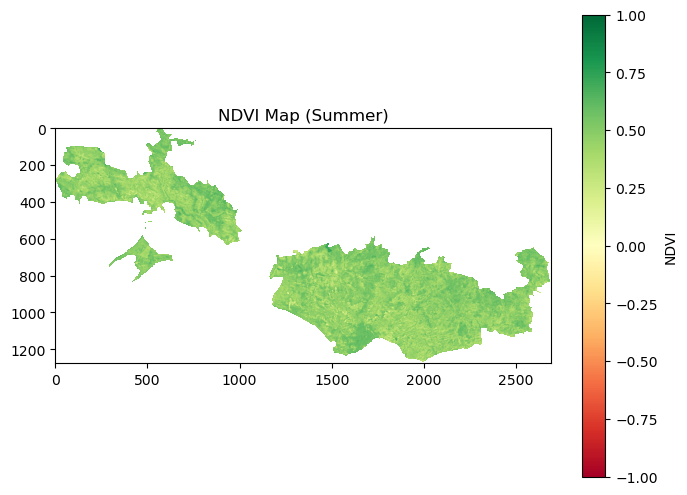

Reprojecting boundary from EPSG:4326 to EPSG:32633


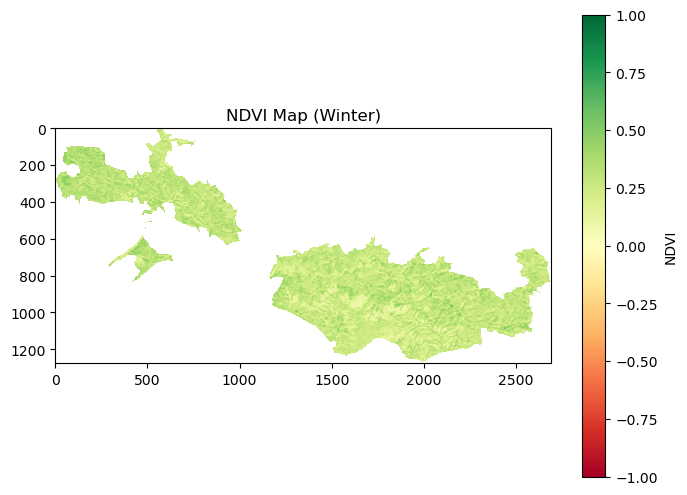

In [5]:
# Process NDVI for each season
for season, paths in seasonal_paths.items():
    red_path, nir_path = paths["red"], paths["nir"]
    
    # Compute NDVI for the given season
    ndvi_map, boundary = load_and_compute_ndvi(red_path, nir_path, boundary_shp)
    
    # Plot the NDVI map
    plt.figure(figsize=(8, 6))
    plt.imshow(ndvi_map, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title(f'NDVI Map ({season})')
    plt.show()

Reprojecting boundary from EPSG:4326 to EPSG:32633
Reprojecting boundary from EPSG:4326 to EPSG:32633


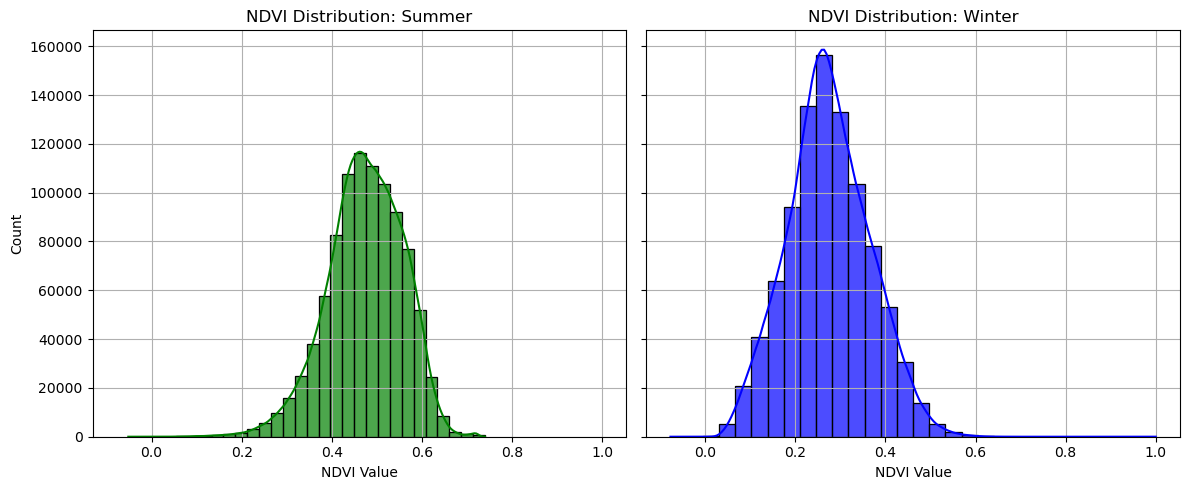

In [6]:

# Compute NDVI for each season
ndvi_data = {season: load_and_compute_ndvi(paths["red"], paths["nir"], boundary_shp)[0].flatten()
             for season, paths in seasonal_paths.items()}

# Plot Side-by-Side Histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, (season, color) in zip(axes, [("Summer", "green"), ("Winter", "blue")]):
    sns.histplot(ndvi_data[season], bins=30, kde=True, color=color, alpha=0.7, ax=ax)
    ax.set_title(f"NDVI Distribution: {season}")
    ax.set_xlabel("NDVI Value")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [7]:

# Compute NDVI for Summer and Winter
ndvi_summer, _ = load_and_compute_ndvi(seasonal_paths["Summer"]["red"], seasonal_paths["Summer"]["nir"], boundary_shp)
ndvi_winter, _ = load_and_compute_ndvi(seasonal_paths["Winter"]["red"], seasonal_paths["Winter"]["nir"], boundary_shp)

# Compute NDVI Difference (Summer - Winter)
ndvi_diff = ndvi_summer - ndvi_winter


# --- Compute NDVI Difference Statistics ---
stats = {
    "Mean NDVI Difference": np.nanmean(ndvi_diff),
    "Standard Deviation": np.nanstd(ndvi_diff),
    "Minimum NDVI Difference": np.nanmin(ndvi_diff),
    "Maximum NDVI Difference": np.nanmax(ndvi_diff),
    "Total Pixels Analyzed": np.count_nonzero(~np.isnan(ndvi_diff))
}

# Print NDVI Difference Statistics in a Clear Format
print("\n=== NDVI Difference Statistics (Summer - Winter) ===")
for key, value in stats.items():
    print(f"{key}: {value:.4f}")


Reprojecting boundary from EPSG:4326 to EPSG:32633
Reprojecting boundary from EPSG:4326 to EPSG:32633

=== NDVI Difference Statistics (Summer - Winter) ===
Mean NDVI Difference: 0.2003
Standard Deviation: 0.1150
Minimum NDVI Difference: -0.6330
Maximum NDVI Difference: 0.6801
Total Pixels Analyzed: 937214.0000


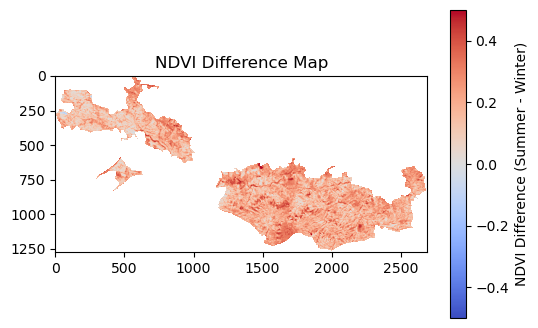

In [8]:

# --- Plot NDVI Difference Map ---
plt.figure(figsize=(6, 4))
plt.imshow(ndvi_diff, cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar(label="NDVI Difference (Summer - Winter)")
plt.title("NDVI Difference Map")
plt.show()



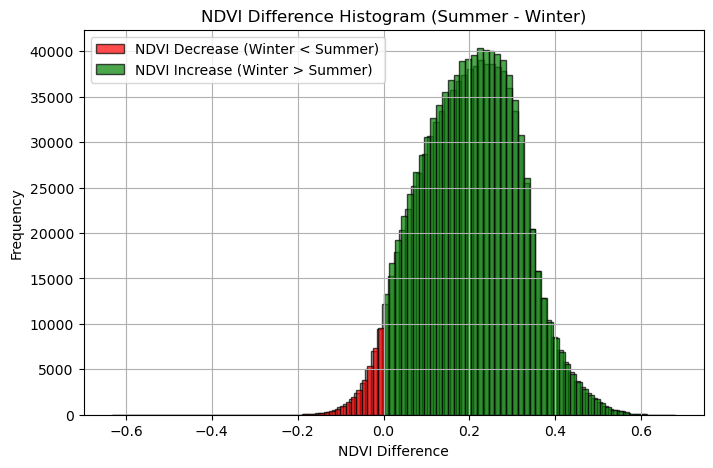

In [9]:
# Define color scheme
colors = ['red' if x < 0 else 'green' for x in ndvi_diff.flatten()]

# Create NDVI Difference Histogram with Two Colors
plt.figure(figsize=(8, 5))
plt.hist(ndvi_diff.flatten(), bins=100, color='gray', alpha=0.7, edgecolor='black')

# Overlay two colors
plt.hist(ndvi_diff.flatten()[ndvi_diff.flatten() < 0], bins=50, color='red', alpha=0.7, edgecolor='black', label='NDVI Decrease (Winter < Summer)')
plt.hist(ndvi_diff.flatten()[ndvi_diff.flatten() > 0], bins=50, color='green', alpha=0.7, edgecolor='black', label='NDVI Increase (Winter > Summer)')

# Titles and labels
plt.title("NDVI Difference Histogram (Summer - Winter)")
plt.xlabel("NDVI Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

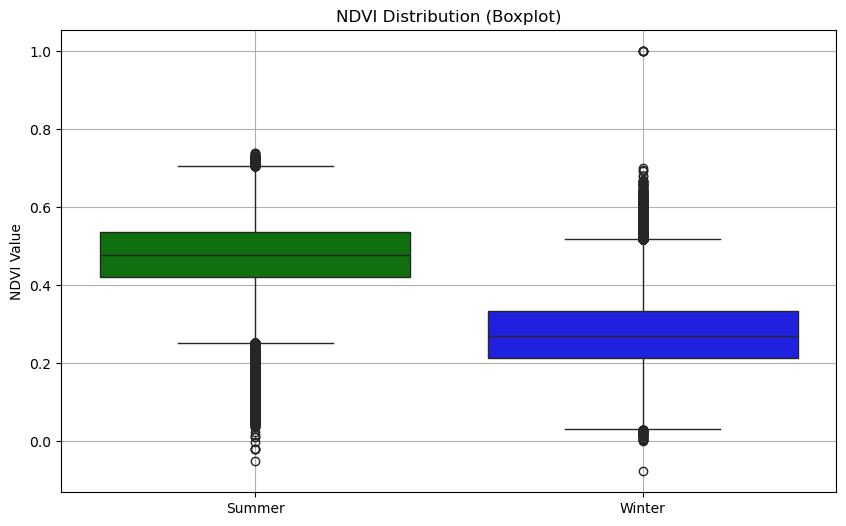

In [10]:
# Plot NDVI Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[ndvi_data["Summer"], ndvi_data["Winter"]], palette=["green", "blue"])
plt.xticks([0, 1], ["Summer", "Winter"])
plt.ylabel("NDVI Value")
plt.title("NDVI Distribution (Boxplot)")
plt.grid(True)
plt.show()